# CIC-IDS2017 Dataset - Exploratory Data Analysis

Analysis of missing values and label distribution for the CIC-IDS2017 network traffic dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
sns.set_style('whitegrid')

## Load CIC-IDS2017 Dataset

In [2]:
# Define path and get CSV files
cic_path = '/home/sagemaker-user/data/CIC-IDS2017'
cic_files = sorted(Path(cic_path).glob('*.csv'))

print(f"CIC-IDS2017 files: {len(cic_files)}")
for file in cic_files:
    print(f"  - {file.name}")

CIC-IDS2017 files: 8
  - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
  - Friday-WorkingHours-Morning.pcap_ISCX.csv
  - Monday-WorkingHours.pcap_ISCX.csv
  - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
  - Tuesday-WorkingHours.pcap_ISCX.csv
  - Wednesday-workingHours.pcap_ISCX.csv


In [3]:
# Load and concatenate all files
print("Loading CIC-IDS2017 dataset...")

cic_dfs = []
for i, file in enumerate(cic_files, 1):
    print(f"  [{i}/{len(cic_files)}] {file.name}")
    df = pd.read_csv(file)
    cic_dfs.append(df)

cic_data = pd.concat(cic_dfs, ignore_index=True)
print(f"\nTotal shape: {cic_data.shape}")
print(f"Rows: {cic_data.shape[0]:,}")
print(f"Columns: {cic_data.shape[1]}")

Loading CIC-IDS2017 dataset...
  [1/8] Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  [2/8] Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
  [3/8] Friday-WorkingHours-Morning.pcap_ISCX.csv
  [4/8] Monday-WorkingHours.pcap_ISCX.csv
  [5/8] Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  [6/8] Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
  [7/8] Tuesday-WorkingHours.pcap_ISCX.csv
  [8/8] Wednesday-workingHours.pcap_ISCX.csv

Total shape: (2830743, 79)
Rows: 2,830,743
Columns: 79


## Missing Values Analysis

In [4]:
print("CIC-IDS2017 MISSING VALUES\n")

missing = cic_data.isnull().sum()
missing_pct = (missing / len(cic_data)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)

print(f"Total missing values: {missing.sum():,}")
print(f"Columns with missing values: {(missing > 0).sum()}")
print(f"Total columns: {len(missing)}")

if missing.sum() > 0:
    print("\nColumns with missing values:")
    display(missing_df[missing_df['Missing Count'] > 0])
else:
    print("\nNo missing values found!")

CIC-IDS2017 MISSING VALUES

Total missing values: 1,358
Columns with missing values: 1
Total columns: 79

Columns with missing values:


,Missing Count,Percentage
Flow Bytes/s,1358,0.047973


## Label Distribution Analysis

**Label Structure**: Combined label with BENIGN + various attack types (DoS, DDoS, PortScan, Bot, Web Attacks, Infiltration, Heartbleed)

In [5]:
print("CIC-IDS2017 LABEL DISTRIBUTION\n")

# Find label column
label_col = None
for col in cic_data.columns:
    if col.lower() == 'label' or col == ' Label':
        label_col = col
        break

if label_col:
    # Get all unique labels
    all_labels = cic_data[label_col].value_counts()
    all_labels_pct = (all_labels / len(cic_data) * 100)
    
    labels_df = pd.DataFrame({
        'Count': all_labels,
        'Percentage': all_labels_pct.round(2)
    })
    
    print(f"Label Column: '{label_col}'")
    display(labels_df)
    print(f"\nTotal unique labels: {len(all_labels)}")
    print(f"Total samples: {len(cic_data):,}")
    
    # Separate BENIGN vs Attack
    benign_mask = cic_data[label_col].str.upper() == 'BENIGN'
    benign_count = benign_mask.sum()
    attack_count = (~benign_mask).sum()
    
    print(f"\nBinary Classification:")
    print(f"  BENIGN: {benign_count:,} ({benign_count/len(cic_data)*100:.2f}%)")
    print(f"  Attack: {attack_count:,} ({attack_count/len(cic_data)*100:.2f}%)")
else:
    print("Label column not found")

CIC-IDS2017 LABEL DISTRIBUTION

Label Column: ' Label'


,Count,Percentage
Label,,
BENIGN,2273097,80.30
DoS Hulk,231073,8.16
PortScan,158930,5.61
DDoS,128027,4.52
DoS GoldenEye,10293,0.36
FTP-Patator,7938,0.28
SSH-Patator,5897,0.21
DoS slowloris,5796,0.20
DoS Slowhttptest,5499,0.19



Total unique labels: 15
Total samples: 2,830,743

Binary Classification:
  BENIGN: 2,273,097 (80.30%)
  Attack: 557,646 (19.70%)


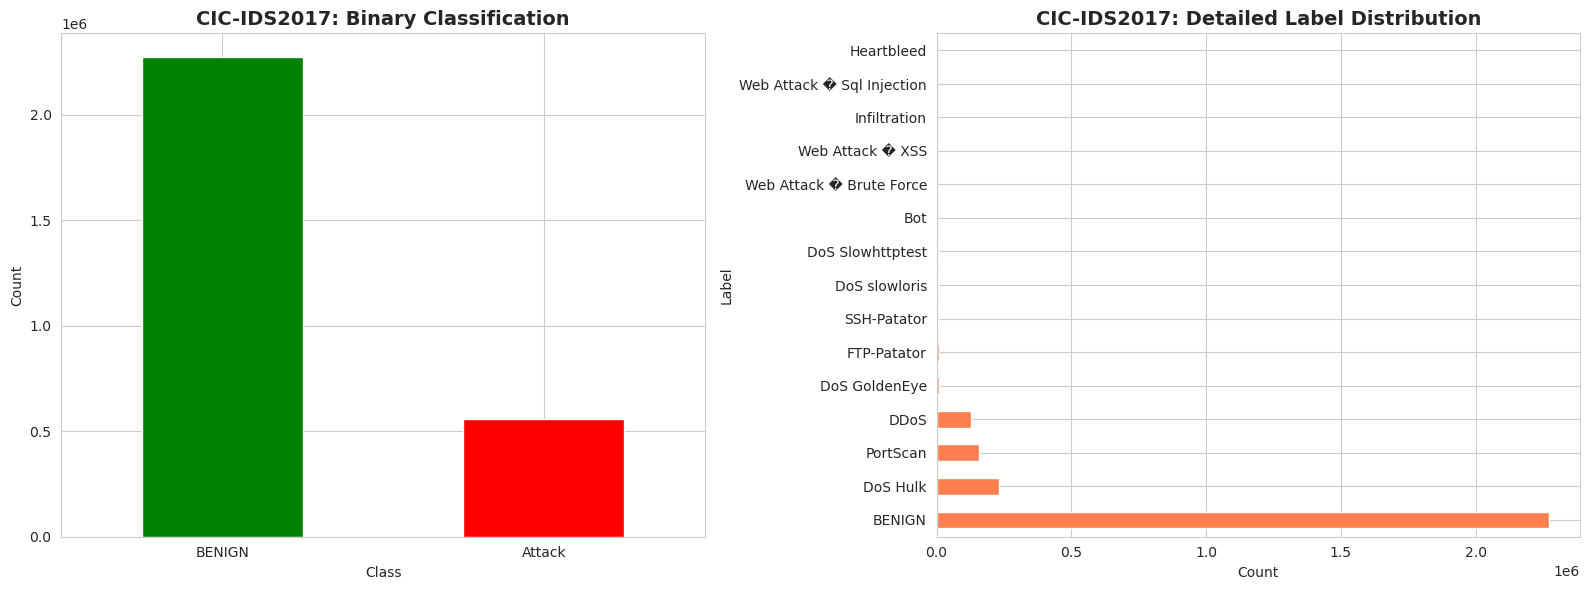

In [6]:
if label_col:
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Binary distribution
    pd.Series({'BENIGN': benign_count, 'Attack': attack_count}).plot(
        kind='bar', ax=axes[0], color=['green', 'red']
    )
    axes[0].set_title('CIC-IDS2017: Binary Classification', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=0)
    
    # All attack types
    all_labels.plot(kind='barh', ax=axes[1], color='coral')
    axes[1].set_title('CIC-IDS2017: Detailed Label Distribution', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Count')
    axes[1].set_ylabel('Label')
    
    plt.tight_layout()
    plt.show()